In [20]:
from dask_image.imread import imread

In [21]:
#filter_list = (
#    filters.Gaussian,
#    filters.LaplacianOfGaussian,
#    filters.GaussianGradientMagnitude,
#    filters.DifferenceOfGaussians,
#    filters.StructureTensorEigenvalues,
#   filters.HessianOfGaussianEigenvalues,)

In [22]:
from typing import Sequence

import dask.array as da
from dask_image.ndfilters import (
    gaussian_filter,
    gaussian_gradient_magnitude,
    gaussian_laplace,
    laplace,
)

from ilastik.napari.filters import GaussianDask, FilterSet

features=FilterSet( filters=[GaussianDask( scale=0.3 ),GaussianDask( scale=0.7 ) ] ) # -> we use dask filters
features

FilterSet(filters=[GaussianDask(scale=0.3), GaussianDask(scale=0.7)])

In [23]:
import numpy as np
import dask
from sklearn.pipeline import Pipeline

from spatialdata import read_zarr

dask.config.set({'distributed.worker.daemon': False})

path = r"C:\Users\matti\Documents\WERK\STAGE\VIB\output" # change this

sdata = read_zarr(r"C:\Users\matti\Documents\WERK\STAGE\VIB\sdata_multi_channel.zarr\sdata_multi_channel.zarr")

#image=imread( "/Users/arnedf/VIB/DATA/test_data_ilastik/fov0/*.tiff" )

image=sdata[ "raw_image" ].data
image

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\zarr\creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\spatialdata\models\models.py:1087: UserWarning: The geometry column of the GeoDataFrame has 3 dimensions, while 2 is expected. Please consider discarding the third dimension as it could led to unexpected behaviors. To achieve so, you can use `.force_2d()` if you are using `geopandas > 0.14.3, otherwise you can use `force_2d()` from `spatialdata.models`.
  schema().validate(e)
c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\spatialdata\_core\_elements.py:109: UserWarning: The geometry column of the GeoDataFrame has 3 dimensions, while 2 is expected. Please consider discarding the third dimension as it could led to unexpected behaviors. To achieve so, you can use `.force_2d()` if you are using `geopand

dask.array<from-zarr, shape=(22, 512, 512), dtype=float32, chunksize=(22, 512, 512), chunktype=numpy.ndarray>

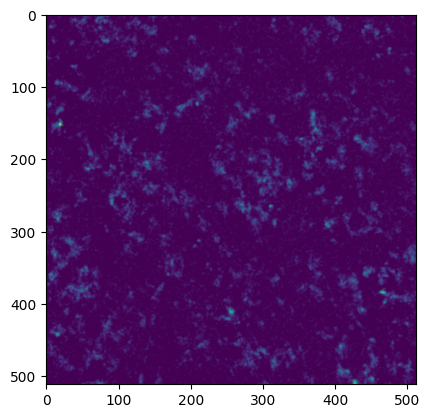

In [24]:
from matplotlib.pyplot import imshow

imshow( image[0] )  # we only plot the first channel

In [25]:
import os
import joblib

def preprocessing_dask(image, estimators, preprocessing_path=None):
    pipe = Pipeline(estimators)
    feature_map_lazy = pipe.transform(image)
    feature_map_lazy.to_zarr( os.path.join( preprocessing_path, "array.zarr"), overwrite=True ) # this could be large, so we write to zarr store
    joblib.dump(pipe, os.path.join( preprocessing_path, "preprocessing_pipe.pkl" ))

features=FilterSet( filters=[GaussianDask( scale=0.3 ),GaussianDask( scale=0.7 ) ] )
estimators = [("features", features)]

preprocessing_path = path

preprocessing_dask( image[0], estimators=estimators, preprocessing_path = preprocessing_path )

In [26]:
preprocessed_image=da.from_zarr( os.path.join( preprocessing_path, "array.zarr" ) )

preprocessed_image # preprocessed image

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\zarr\creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<from-zarr, shape=(512, 512, 2), dtype=float32, chunksize=(512, 512, 1), chunktype=numpy.ndarray>

In [27]:
# create some dummy annotations

labels = np.random.choice([0, 1, 2], size=image.shape[1:], p=[0.8, 0.1, 0.1])

In [28]:
from dask.distributed import Client

from ilastik.napari.classifier import NDSparseDaskClassifier
from sklearn.ensemble import RandomForestClassifier

import loguru

logger = loguru.logger

def pixel_training_dask(
    X,labels, model_path=None, **client_kwargs,
):
    clf = NDSparseDaskClassifier(RandomForestClassifier(n_jobs=-1))
    # add the classifier to the pipe, and then dump it
    client = Client(**client_kwargs)
    logger.info(f"Client dashboard link {client.dashboard_link}")

    print(X)
    print(X.shape)

    with joblib.parallel_backend(
        "dask"
    ):  # note, NDSparseDaskClassifier with dask backend will still load data that was annotated in memory (although not the full dataset, only non-zero labels)
        clf.fit(X, labels)

    if model_path is not None:
        joblib.dump(clf, os.path.join(model_path))

# load features from the zarr store
image =  da.from_zarr(os.path.join( preprocessing_path, "array.zarr" ))
pixel_training_dask( X=image, labels=labels, model_path=os.path.join( path, "model.pkl" ), n_workers=1, threads_per_worker=10  )

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60247 instead
  warnings.warn(
2025-02-20 13:15:50.778 | INFO     | __main__:pixel_training_dask:16 - Client dashboard link http://127.0.0.1:60247/status


dask.array<from-zarr, shape=(512, 512, 2), dtype=float32, chunksize=(512, 512, 1), chunktype=numpy.ndarray>
(512, 512, 2)


In [54]:
def pixel_classification_dask(
    image: da.Array | None,
    preprocessing_path,
    model_path,
    tmp_path,
    **client_kwargs,
):
    # WIP
    if image is None:
        # case where we train and run inference on same image
        image = da.from_zarr(preprocessing_path, "array.zarr")
    else:
        # load the preprocessing pipe from the path, do the preprocessing on image, and then do the classification
        # this should be used if we have a new image coming in, that we want to preprocesses and classify using pretrained model.
        preprocessing_pipe = joblib.load(preprocessing_path, "pipe.pkl")
        image = preprocessing_pipe.transform(image)
        # image could be large
        image.to_zarr(tmp_path)
        image.from_zarr(tmp_path)
    clf = joblib.load(model_path)
    client = Client(**client_kwargs)

    clf_scatter = client.scatter(
        clf
    )  # scatter the model otherwise issues with large task graph

    def _predict_clf(arr, model):
        arr = model.predict(arr)
        return arr.squeeze(-1)

    # probably need to use map_overlap instead of map_blocks here
    array_result = da.map_blocks(
        _predict_clf,
        image,
        dtype=image.dtype,
        drop_axis=-1,
        chunks=image.chunks[:-1] + (2,),
        model=clf_scatter,
        # TODO output dtype not correct, need to fix via meta
    )

    results = array_result.compute()
    return results

In [55]:
results=pixel_classification_dask(image = None, preprocessing_path=path, model_path=os.path.join( path, "model.pkl" ), tmp_path = None,  n_workers=1, threads_per_worker=10  )

c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\zarr\creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
c:\Users\matti\.conda\envs\ilastik_napari_182\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60531 instead
  warnings.warn(


In [56]:
results.shape # ->predicted labels

(512, 512)

In [52]:
results.min()

1